In [1]:
import numpy as np
import pandas as pd
import pyreadstat
import statsmodels.api as sm
from scipy.special import factorial
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col
import scipy as sc

In [2]:
dtafile = 'h163.dta'
df, meta = pyreadstat.read_dta(dtafile)
df_subset = df[['SEX','TOTEXP13','TTLP13X','INSCOV13','EDUYRDG','AGE31X','RACEV1X','REGION13','BMINDX53','ADSMOK42','HIBPDX','MARRY13X','RTHLTH31']].copy()
               # 'MNHLTH31','PRIJA15','HIBPDX','EMPST31','TOTEXP15','OBDRV15', 'SEX']].copy()
#df_subset['AGE15X_sq'] = np.power(df_subset['AGE15X'],2)
df_use=df_subset[df_subset['SEX']==1].copy()

In [3]:
# Drop all the not interesting values
df_use = df_use.drop(df_use[df_use['RTHLTH31'].isin([-9, -8, -7,-1])].index)
df_use = df_use.drop(df_use[df_use['AGE31X']==-1].index)
df_use = df_use.drop(df_use[df_use['AGE31X']<18].index)
df_use = df_use.drop(df_use[df_use['TOTEXP13']==0].index)

df_use = df_use.drop(df_use[df_use['TTLP13X']<0].index)
# Data preparation
df_use.rename(columns = {'TOTEXP13' : 'Health Expenditure'}, inplace = True)
df_use.rename(columns = {'TTLP13X' : 'Income'}, inplace = True)
df_use.rename(columns = {'AGE31X' : 'Age'}, inplace = True)
df_use['Insured']=np.where(df_use['INSCOV13'] < 3,1,0)# insured (publicly or privately)

df_use=df_use.drop(df_use[(df_use['EDUYRDG']==-1) | (df_use['EDUYRDG']==-7) | 
                          (df_use['EDUYRDG']==10) | (df_use['EDUYRDG']==-8) | (df_use['EDUYRDG']==-9)].index)
df_use['University<']=np.where(df_use['EDUYRDG']>7, 1, 0) #BSc & MSc
df_use['High School<']=np.where((df_use['EDUYRDG']<8) & (df_use['EDUYRDG']>3), 1, 0) #at least high school
df_use['Race White']=np.where(df_use['RACEV1X']==1, 1, 0)
df_use['Northeast'] = np.where(df_use['REGION13']==1,1,0)
df_use['Midwest'] = np.where(df_use['REGION13']==2,1,0)
df_use['South'] = np.where(df_use['REGION13']==3,1,0)
df_use['West'] = np.where(df_use['REGION13']==4,1,0)
df_use['Obese'] = np.where(df_use['BMINDX53']>=30,1,0) # niet voor 17 of jonger (jonger dan 17 krijgt dus automatisch geen obese)
df_use['Smoker'] = np.where(df_use['ADSMOK42']==1,1,0)
df_use['High Blood Pressure'] = np.where(df_use['HIBPDX'] == 1, 1, 0) #niet voor 17 of jonger (jonger dan 17 krijgt dus automatisch geen High Blood Pressure)
df_use['Married'] = np.where(df_use['MARRY13X']==1,1,0) #1 for married
df_use.drop(['EDUYRDG', 'INSCOV13','SEX','REGION13','RACEV1X','BMINDX53','ADSMOK42','HIBPDX'],inplace=True, axis = 1)
df_use = df_use.join(pd.get_dummies(df_use['RTHLTH31'].replace({})).rename({1: 'Excellent Health', 2:'Very good Health',3:'Good Health',4:'Fair Health ',5:'Poor Health'}, axis=1))


In [4]:
# Re-scaling some variables
df_use['Income'] = np.log(df_use['Income']+1)
df_use['Health Expenditure'] = np.log(df_use['Health Expenditure'])

In [5]:
# Defining variables for probit estimation
S = df_use['Insured'].to_numpy()
dep_first_stage = ['Income', 'University<','High School<','Smoker','Age','Race White','Married','Northeast','Midwest','South','Very good Health','Good Health','Fair Health ','Poor Health']
Z = df_use[dep_first_stage].to_numpy()
Z = np.concatenate([Z, np.ones((S.shape[0], 1))], axis=1)
init_gamma = np.array(np.repeat(0, Z.shape[1]))

In [6]:
# Defining control variables for final OLS estimation
y = df_use['Health Expenditure'].to_numpy()
dep_second_stage = ['Income', 'University<','High School<','Obese','Smoker','High Blood Pressure','Age','Race White','Married','Northeast','Midwest','South','Very good Health','Good Health','Fair Health ','Poor Health']
X = df_use[dep_second_stage].to_numpy()
X = np.concatenate([X, np.ones((y.shape[0], 1))], axis=1) # Depending on implementing constant

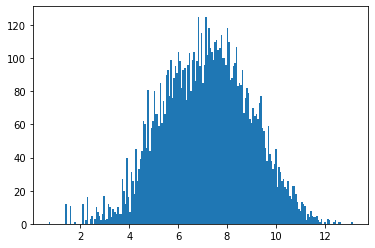

In [7]:
import matplotlib.pyplot as plt

plt.hist(y, bins = 200)
plt.show()

In [8]:
print(df_use[['Health Expenditure','Income','Age']].describe().T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   count &       mean &        std &        min &        25\% &        50\% &        75\% &        max \\
\midrule
Health Expenditure &  8242.0 &   7.149230 &   1.807825 &   0.693147 &   5.857933 &   7.181592 &   8.422168 &  13.151281 \\
Income             &  8242.0 &   9.542599 &   2.723702 &   0.000000 &   9.406935 &  10.241744 &  10.868587 &  12.743262 \\
Age                &  8242.0 &  47.505581 &  17.424506 &  18.000000 &  33.000000 &  48.000000 &  60.000000 &  85.000000 \\
\bottomrule
\end{tabular}



In [9]:
print(df_use[['Insured','University<','High School<','Race White','Northeast','Midwest','South','West','Obese','Smoker','High Blood Pressure','Married','Excellent Health','Very good Health','Good Health','Fair Health ','Poor Health']].describe().T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   count &      mean &       std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
Insured             &  8242.0 &  0.855982 &  0.351130 &  0.0 &  1.0 &  1.0 &  1.0 &  1.0 \\
University<         &  8242.0 &  0.258068 &  0.437598 &  0.0 &  0.0 &  0.0 &  1.0 &  1.0 \\
High School<        &  8242.0 &  0.479374 &  0.499605 &  0.0 &  0.0 &  0.0 &  1.0 &  1.0 \\
Race White          &  8242.0 &  0.698738 &  0.458834 &  0.0 &  0.0 &  1.0 &  1.0 &  1.0 \\
Northeast           &  8242.0 &  0.168163 &  0.374034 &  0.0 &  0.0 &  0.0 &  0.0 &  1.0 \\
Midwest             &  8242.0 &  0.194249 &  0.395645 &  0.0 &  0.0 &  0.0 &  0.0 &  1.0 \\
South               &  8242.0 &  0.349794 &  0.476934 &  0.0 &  0.0 &  0.0 &  1.0 &  1.0 \\
West                &  8242.0 &  0.282941 &  0.450455 &  0.0 &  0.0 &  0.0 &  1.0 &  1.0 \\
Obese               &  8242.0 &  0.312060 &  0.463362 &  0.0 &  0.0 &  0.0 &  1.0 &  1.0 \\
Smoker              &  8242.0 &  0.165494 &  0.37

In [10]:
def Probit_Objective (vBeta0, vY, mX):
    
    iSizeN, iSizeK = np.shape(mX)
    vY_tilde = (2*vY-1).reshape(iSizeN,1)
    
    mXy_tilde = np.multiply(mX,vY_tilde)
    
    vFitted_tilde = mXy_tilde@(np.asmatrix(vBeta0).reshape(iSizeK,1)) 

    vObj = np.log(norm.cdf(vFitted_tilde))
    dLogL = -np.mean(vObj)
    
    return dLogL

In [11]:
def Probit_hessian(vBeta0,vY,mX):
    N, K = np.shape(mX)
    beta = vBeta0
    
    hessian=0
    for i in range(N):
        Phi_ij = -((vY[i]*1/(norm.cdf(mX[i,:]@beta))*norm.pdf(mX[i,:]@beta)*mX[i,:]@beta
                   +vY[i]*1/(norm.cdf(mX[i,:]@beta))**2*norm.pdf(mX[i,:]@beta)**2)*np.outer(mX[i,:],mX[i,:])
                   +((1-vY[i])*1/(1-norm.cdf(mX[i,:]@beta))**2*norm.pdf(mX[i,:]@beta)**2
                   -(1-vY[i])*1/(1-norm.cdf(mX[i,:]@beta))*norm.pdf(mX[i,:]@beta)*mX[i,:]@beta)*np.outer(mX[i,:],mX[i,:])
                  )
        hessian = hessian + Phi_ij
    return hessian

In [12]:
def Probit_score(vBeta0,vY,mX):
    N, K = np.shape(mX)
    beta = vBeta0
    
    score=0
    for i in range(N):
        Phi_ij = vY[i]*1/(norm.cdf(mX[i,:]@beta))*norm.pdf(mX[i,:]@beta)*mX[i,:]
        Phi_ij_1 = (1-vY[i])*1/(1-norm.cdf(mX[i,:]@beta))*norm.pdf(mX[i,:]@beta)*mX[i,:]
        Zln = Phi_ij - Phi_ij_1
        score = score + Zln
           # break
            # else:
            #     Zln = 0
    return score

In [13]:
def newton_raphson(X,y,beta,itermax,tol):
    b=beta
    iSize, iSizeK = np.shape(X)
    for i in range(itermax):
        logl=Probit_Objective (b, y, X)
        score=np.asmatrix(Probit_score(b, y, X)).reshape(iSizeK,1)
        hessian=Probit_hessian(b, y, X)
        hessian_inv=np.linalg.inv(hessian)
        a=np.array((hessian_inv @ score).transpose())[0]
        b=b-a
        up_logl=Probit_Objective(b, y, X)
        if (abs(logl - up_logl)<tol):
            print('convergence reached')
            print('The log-likelihood is: {}'.format(-up_logl*len(y)))
            break
    return b

In [14]:
def probit_se(b,y,X):
    var=np.linalg.inv(Probit_hessian(b, y, X))
    return np.sqrt(-np.diag(var))

def probit_p_value(b,se,df):
    t=b/se
    p=2*(1-stats.t.cdf(abs(t),df=df))
    return t,p 

In [15]:
gamma = newton_raphson(Z,S,init_gamma,100,0.01)
gamma_SE = probit_se(gamma,S,Z)
gamma_t, gamma_pval = probit_p_value(gamma, gamma_SE, Z.shape[0]-1)

convergence reached
The log-likelihood is: -3050.4480903673402


In [16]:
dep_first_stage_names = np.append(dep_first_stage,'Constant')
Table=pd.DataFrame({
    "Variable"  : dep_first_stage_names,
    "Coefficients": gamma,
    "SE": gamma_SE,
    "t-stat": gamma_t,
    "p-value": gamma_pval
    #"Marginal Effect":marg
}).round({"Coefficients": 4, "SE": 3,"t-stat":3, "p-value": 3})#"Marginal Effect":3})
Table.index = Table["Variable"]
del Table["Variable"]
print(Table.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Coefficients &     SE &  t-stat &  p-value \\
Variable         &               &        &         &          \\
\midrule
Income           &        0.0323 &  0.006 &   5.239 &    0.000 \\
University<      &        0.7200 &  0.059 &  12.191 &    0.000 \\
High School<     &        0.2650 &  0.041 &   6.474 &    0.000 \\
Smoker           &       -0.1659 &  0.046 &  -3.629 &    0.000 \\
Age              &        0.0154 &  0.001 &  12.776 &    0.000 \\
Race White       &       -0.1792 &  0.041 &  -4.393 &    0.000 \\
Married          &        0.1579 &  0.039 &   4.062 &    0.000 \\
Northeast        &        0.2341 &  0.058 &   4.001 &    0.000 \\
Midwest          &        0.1547 &  0.055 &   2.828 &    0.005 \\
South            &       -0.0766 &  0.045 &  -1.716 &    0.086 \\
Very good Health &        0.0720 &  0.051 &   1.423 &    0.155 \\
Good Health      &       -0.0785 &  0.051 &  -1.544 &    0.123 \\
Fair Health      &       -0.1431 &  0.064 &  -2.2

In [17]:
# Calculating the indices for all observations with S = 1 and S = 0
index_1 = [index for index,value in enumerate(S) if value == 1]
index_1 = np.array(index_1)

index_2 = [index for index,value in enumerate(S) if value == 0]
index_2 = np.array(index_2)

In [18]:
# Calculating the corresponding threshold accordingly through the number of thresholds
Z_gamma = Z @ gamma

g1 = np.zeros(Z_gamma.shape[0])
g2 = np.zeros(Z_gamma.shape[0])

Z_gamma_1 = Z_gamma[index_1]
Z_gamma_2 = Z_gamma[index_2]

g1[index_1] = Z_gamma_1
g2[index_2] = Z_gamma_2

g1_trans = norm.cdf(g1)
g2_trans = norm.cdf(g2)

min_threshold = np.min(norm.cdf(Z_gamma))
max_threshold = np.max(norm.cdf(Z_gamma))
# nr_thresholds result in the # number of dummies
nr_thresholds = 3
thresholds = np.zeros(nr_thresholds+1)
for i in range(nr_thresholds+1):
    thresholds[i]=min_threshold+i*(max_threshold-min_threshold)/nr_thresholds
thresholds

array([0.39977202, 0.59793574, 0.79609947, 0.99426319])

In [19]:
# Creating the dummies due to threshold values for g1
dummy2 = np.zeros((len(g1_trans),1))

for i in range(nr_thresholds):
    dummy  = np.where((g1_trans < thresholds[i+1]) & (g1_trans > thresholds[i]), 1, 0).reshape((len(g1_trans),1))
    dummy2 = np.concatenate([dummy2, dummy], axis=1)

dummies_1 = np.delete(dummy2, 0, 1)
dummies_g1 = np.delete(dummies_1, -1, 1)

# Creating the dummies due to threshold values for g2
dummy2 = np.zeros((len(g2_trans),1))

for i in range(nr_thresholds):
    dummy  = np.where((g2_trans < thresholds[i+1]) & (g2_trans > thresholds[i]), 1, 0).reshape((len(g2_trans),1))
    dummy2 = np.concatenate([dummy2, dummy], axis=1)

dummies_2 = np.delete(dummy2, 0, 1)
dummies_g2 = np.delete(dummies_2, -1, 1)


In [20]:
# Making one large matrix for OLS estimation
X_S   = np.concatenate([X, S.reshape(len(S),1)], axis=1)
X_S_Z = np.concatenate([X_S, dummies_g1, dummies_g2
                       ], axis=1)

X_S_Z.shape

(8242, 22)

In [21]:
# Do the final estimation
beta_OLS = np.linalg.inv(X_S_Z.T @ X_S_Z) @ X_S_Z.T @ y

In [25]:
n, p = X_S_Z.shape
BOOTREP = 100
    
# Initilize bootstrap array
beta_OLS_B = np.zeros((BOOTREP,p))
    
# Balanced bootstrap    
np.random.seed(1)
index_B = np.random.permutation(np.repeat(np.arange(n),BOOTREP)).reshape((BOOTREP,n))
for b in range(BOOTREP):
    index = index_B[b,:]  # select the indices
    yB = np.copy(y[index])
    SB = np.copy(S[index])
    XB = np.copy(X[index,:])
    ZB = np.copy(Z[index,:])
    # Probit estimation
    init_gamma = np.zeros(Z.shape[1])
    gammaB = newton_raphson(ZB, SB, init_gamma, 100, 0.001)
    #gammaB = ML_builtin(init_gamma, SB, ZB)
    
    gammaB = np.array(gammaB).reshape(gammaB.shape[0])
    
    Z_gamma_B = ZB @ gammaB
        
    index_1 = [index for index,value in enumerate(SB) if value == 1]
    index_1 = np.array(index_1)

    index_2 = [index for index,value in enumerate(SB) if value == 0]
    index_2 = np.array(index_2)
    
    g1_B = np.zeros(Z_gamma_B.shape[0])
    g2_B = np.zeros(Z_gamma_B.shape[0])

    Z_gamma_1_B = Z_gamma_B[index_1]
    Z_gamma_2_B = Z_gamma_B[index_2]

    g1_B[index_1] = Z_gamma_1_B
    g2_B[index_2] = Z_gamma_2_B

    g1_trans_B = norm.cdf(g1_B)
    g2_trans_B = norm.cdf(g2_B)

    min_threshold = np.min(norm.cdf(Z_gamma_B))
    max_threshold = np.max(norm.cdf(Z_gamma_B))
    nr_thresholds = 3
    thresholds_B = np.zeros(nr_thresholds+1)
    for i in range(nr_thresholds+1):
        thresholds_B[i]=min_threshold+i*(max_threshold-min_threshold)/nr_thresholds
    thresholds_B

    # Creating the dummies due to threshold values for g1
    dummy1_B = np.zeros((len(g1_trans_B),1))

    for i in range(nr_thresholds):
        dummy  = np.where((g1_trans_B < thresholds_B[i+1]) & (g1_trans_B > thresholds_B[i]), 1, 0).reshape((len(g1_trans_B),1))
        dummy1_B = np.concatenate([dummy1_B, dummy], axis=1)

    dummies_1_B = np.delete(dummy1_B, 0, 1)
    dummies_g1_B = np.delete(dummies_1_B, -1, 1)

    # Creating the dummies due to threshold values for g2
    dummy2_B = np.zeros((len(g2_trans_B),1))

    for i in range(nr_thresholds):
        dummy  = np.where((g2_trans_B < thresholds_B[i+1]) & (g2_trans_B > thresholds_B[i]), 1, 0).reshape((len(g2_trans_B),1))
        dummy2_B = np.concatenate([dummy2_B, dummy], axis=1)

    dummies_2_B = np.delete(dummy2_B, 0, 1)
    dummies_g2_B = np.delete(dummies_2_B, -1, 1)

    # Making one large matrix
    X_S   = np.concatenate([XB, SB.reshape(len(SB),1)], axis=1)
    X_S_Z_B = np.concatenate([X_S, dummies_g1_B, dummies_g2_B
                             ], axis=1)

    # OLS estimation
    beta_OLS_B[b,:] = np.linalg.inv(X_S_Z_B.T @ X_S_Z_B) @ X_S_Z_B.T @ yB

In [26]:
# Calculating the SE for the estimates due to bootstrapping
beta_OLS_SE_B = np.std(beta_OLS_B, axis=0)

#    q_bB_OLS   = np.quantile(bB_OLS,[0.05,0.95],axis=0)

# Calculating the t-values and p-values accordingly
beta_t_OLS, beta_pval_OLS = probit_p_value(beta_OLS, beta_OLS_SE_B, X_S_Z.shape[0]-1)

In [27]:
dep_second_stage_names = np.append(dep_second_stage,['Constant','Insurance', 'Dummy1','Dummy2','Dummy3','Dummy4'#,'Dummy5','Dummy6'
                                                    ])
Table=pd.DataFrame({
    "Variable"  : dep_second_stage_names,
    "Coefficients": beta_OLS,
    "SE": beta_OLS_SE_B,
    "t-stat": beta_t_OLS,
    "p-value": beta_pval_OLS
    #"Marginal Effect":marg
}).round({"Coefficients": 4, "SE": 3,"t-stat":3, "p-value": 3})#"Marginal Effect":3})
Table.index = Table["Variable"]
del Table["Variable"]
print(Table.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Coefficients &     SE &  t-stat &  p-value \\
Variable            &               &        &         &          \\
\midrule
Income              &       -0.0047 &  0.011 &  -0.422 &    0.673 \\
University<         &        0.4187 &  0.062 &   6.731 &    0.000 \\
High School<        &        0.2607 &  0.048 &   5.403 &    0.000 \\
Obese               &        0.0388 &  0.038 &   1.018 &    0.309 \\
Smoker              &       -0.0587 &  0.069 &  -0.854 &    0.393 \\
High Blood Pressure &        0.4268 &  0.044 &   9.772 &    0.000 \\
Age                 &        0.0325 &  0.002 &  18.868 &    0.000 \\
Race White          &        0.0471 &  0.046 &   1.034 &    0.301 \\
Married             &       -0.1882 &  0.040 &  -4.677 &    0.000 \\
Northeast           &        0.1473 &  0.057 &   2.599 &    0.009 \\
Midwest             &        0.2083 &  0.054 &   3.825 &    0.000 \\
South               &       -0.0368 &  0.047 &  -0.780 &    0.436 \\
Very good 

In [ ]:
\begin{tabular}{lrrrr}
\toprule
{} &  Coefficients &     SE &  t-stat &  p-value \\
Variable            &               &        &         &          \\
\midrule
Income              &       -0.0108 &  0.009 &  -1.238 &    0.216 \\
University<         &        0.3667 &  0.057 &   6.482 &    0.000 \\
High School<        &        0.2208 &  0.042 &   5.198 &    0.000 \\
Obese               &        0.0361 &  0.038 &   0.944 &    0.345 \\
Smoker              &       -0.0051 &  0.052 &  -0.099 &    0.921 \\
High Blood Pressure &        0.4181 &  0.044 &   9.454 &    0.000 \\
Age                 &        0.0306 &  0.001 &  22.890 &    0.000 \\
Race White          &        0.0929 &  0.041 &   2.244 &    0.025 \\
Married             &       -0.2233 &  0.037 &  -6.008 &    0.000 \\
Very good Health    &        0.1315 &  0.042 &   3.108 &    0.002 \\
Good Health         &        0.4773 &  0.046 &  10.274 &    0.000 \\
Fair Health         &        0.8829 &  0.068 &  12.942 &    0.000 \\
Poor Health         &        1.6842 &  0.102 &  16.508 &    0.000 \\
Constant            &        3.9833 &  0.221 &  17.985 &    0.000 \\
Insurance           &        0.9994 &  0.148 &   6.740 &    0.000 \\
Dummy1              &        0.2456 &  0.127 &   1.926 &    0.054 \\
Dummy2              &        0.2591 &  0.178 &   1.456 &    0.146 \\
\bottomrule
\end{tabular}

In [ ]:
\begin{tabular}{lrrrr}
\toprule
{} &  Coefficients &     SE &  t-stat &  p-value \\
Variable            &               &        &         &          \\
\midrule
Income              &       -0.0059 &  0.011 &  -0.540 &    0.589 \\
University<         &        0.4012 &  0.062 &   6.473 &    0.000 \\
High School<        &        0.2409 &  0.049 &   4.965 &    0.000 \\
Obese               &        0.0378 &  0.038 &   0.996 &    0.319 \\
Smoker              &       -0.0521 &  0.066 &  -0.786 &    0.432 \\
High Blood Pressure &        0.4283 &  0.044 &   9.815 &    0.000 \\
Age                 &        0.0318 &  0.002 &  14.297 &    0.000 \\
Race White          &        0.0597 &  0.046 &   1.311 &    0.190 \\
Married             &       -0.1976 &  0.040 &  -4.916 &    0.000 \\
Northeast           &        0.1389 &  0.056 &   2.494 &    0.013 \\
Midwest             &        0.2058 &  0.056 &   3.707 &    0.000 \\
South               &       -0.0333 &  0.046 &  -0.727 &    0.467 \\
Very good Health    &        0.1377 &  0.049 &   2.792 &    0.005 \\
Good Health         &        0.4672 &  0.048 &   9.796 &    0.000 \\
Fair Health         &        0.8708 &  0.074 &  11.839 &    0.000 \\
Poor Health         &        1.7092 &  0.105 &  16.350 &    0.000 \\
Constant            &        3.4059 &  0.436 &   7.816 &    0.000 \\
Insurance           &        0.9896 &  0.503 &   1.968 &    0.049 \\
Dummy1              &        0.6332 &  0.341 &   1.858 &    0.063 \\
Dummy2              &        0.2891 &  0.182 &   1.589 &    0.112 \\
Dummy3              &        0.0893 &  0.099 &   0.905 &    0.365 \\
Dummy4              &        0.6464 &  0.482 &   1.342 &    0.180 \\
Dummy5              &        0.5596 &  0.219 &   2.560 &    0.010 \\
Dummy6              &       -0.0284 &  0.159 &  -0.179 &    0.858 \\
\bottomrule
\end{tabular}

## (Using Builtin functions)

In [23]:
def ML_builtin (vBeta0, vY, mX):
    iSize, iSizeK = np.shape(mX)
    # without Hessian
   # res = sc.optimize.minimize(Probit_Objective, np.squeeze(vBeta0),jac=Probit_jacobian, args=(vY, mX), method = 'BFGS')
    # with hession
    res = sc.optimize.minimize(Probit_Objective, np.squeeze(vBeta0),jac=False,args=(vY, mX), method ='Nelder-Mead') #'Nelder-Mead')'Newton-CG')
    vBeta_new = np.asmatrix(res.x).reshape(iSizeK,1)
    return vBeta_new